In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
torch.cuda.empty_cache()

random_seed = 0
torch.manual_seed(random_seed)

In [2]:
classes = 94
skdim = 10
noise = 2
dim_multiplier = 100
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
def uniform_initializer(out_dim, in_dim, cuda = True):
    tensor = torch.empty(out_dim, in_dim)
    if cuda:
        return torch.nn.init.uniform_(tensor, a=-2, b=2).cuda()
    else: 
        return torch.nn.init.uniform_(tensor, a=-2, b=2)

def uniform_initializer2(out_dim, in_dim, cuda = True):
    tensor = torch.empty(out_dim, in_dim)
    if cuda:
        return torch.nn.init.uniform_(tensor, a=-0.5, b=0.5).cuda()
    else: 
        return torch.nn.init.uniform_(tensor, a=-0.5, b=0.5)

In [4]:
#secret keys
#ascii 0-94
secret_key = uniform_initializer(skdim, classes)
print(secret_key.shape)

torch.Size([5, 94])


In [234]:
# noise 
def apply_gaussian_noise(tensor, sd, device = torch.device("cuda:0")):
    tensor = tensor + (sd)*torch.randn(*tuple(tensor.shape)).to(device)
    return tensor

class simple_encoder_wthreshold():
    def __init__(self, out_dim, in_dim, epsilon, cuda = True):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.W = uniform_initializer(out_dim, in_dim, cuda)
        self.device = torch.device("cuda:0") if cuda else torch.device("cpu")
        self.epsilon = epsilon
        
    def apply(self, X):
        return (torch.matmul(self.W, X) > self.epsilon).float()
    
    def apply_wnoise(self, X, sd):
        #print(X.shape, self.W.shape)
        if sd == 0:
            return self.apply(X)
        return (torch.matmul(apply_gaussian_noise(self.W, sd, device = self.device), X) > self.epsilon).float()
    
    def apply_wnoise_realistic(self, X, sd):
        #print(X.shape, self.W.shape)
        if sd == 0:
            return self.apply(X)
        encoded = torch.zeros((self.out_dim, X.shape[1])).to(self.device)
        for i in range(X.shape[1]):
            encoded[:,i] = (torch.matmul(apply_gaussian_noise(self.W, sd, device = self.device), X[:,i].view(-1,1)) > self.epsilon).float().view(-1)
        return encoded
    


In [235]:
#One hot net    

class One_hot_net(nn.Module):
    def __init__(self, in_dim, n_class, f_encoder, encoder_multiplier, f_initializer, epsilon):
        super(One_hot_net, self).__init__()
        self.in_dim = in_dim
        feature_len = in_dim * encoder_multiplier
        self.feature_len = feature_len
        self.epsilon = epsilon
        self.n_class = n_class
        self.f_encoder = f_encoder
        self.f_initializer = f_initializer
        self.tail = nn.Linear(feature_len, n_class)

    def forward(self, X):
        X = self.f_encoder.apply_wnoise(X, noise)
        X = torch.transpose(X, 0, 1)
        X = self.tail(X)
        return X.transpose(1,0)
    
    def decrypt(self, X):
        X = torch.transpose(X, 0, 1)
        X = self.tail(X)
        return X.transpose(1,0)

In [236]:
parameters = {
    'in_dim': 10,
    'n_class': 10,
    'f_encoder': simple_encoder_wthreshold(10*dim_multiplier, 10, 0),
    'f_initializer': uniform_initializer,
    'encoder_multiplier': dim_multiplier,
    'epsilon': 10e-3,
    'n_layers': 1,
    'layer_size_factor': [1],
    'dropout': [-1]
}

In [237]:
device = torch.device("cuda:0")
model1 = One_hot_net(parameters['in_dim'], parameters['n_class'], parameters['f_encoder'], parameters['encoder_multiplier'], 
                     parameters['f_initializer'], parameters['epsilon']).to(device)

optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.005, momentum=0.5)


In [238]:
#create training and testing set
def make_data(size):
    data = torch.rand(size) * classes
    return data.long()

n_epochs = 50
n_batch = 2000
batch_size_train = 50
batch_size_test = 50

train_loader = [secret_key[:, make_data(batch_size_train)] for i in range(n_batch)]
test_loader = [secret_key[:, make_data(batch_size_test)] for i in range(n_batch)]

print(train_loader[0].shape)

torch.Size([10, 50])


In [239]:
train_losses = []
test_losses = []

In [240]:
def train(epoch, model, optimizer, trainloader, log_interval = 10, device = torch.device("cuda:0")):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.MSELoss()(output, data)
        loss.backward()
        optimizer.step()
        train_loss += loss
    train_loss /= len(train_loader)
    train_losses.append(float(train_loss))
    print('Epoch: {}, Train set: Avg. loss: {:.6f}'.format(epoch,
        train_loss))
    return model, optimizer
def test(model, test_loader, device = torch.device("cuda:0")):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            output = model(data)
            test_loss += nn.MSELoss()(output, data).item()
    test_loss /= len(test_loader)
    test_losses.append(float(test_loss))
    #print(output[:,0]-data[:,0])
    print('Test set: Avg. loss: {:.6f}'.format(
        test_loss))
    return test_loss

In [241]:
model_name = "crypto_net1"
for epoch in range(1, n_epochs + 1):
    train(epoch, model1, optimizer1, train_loader)
    test(model1, test_loader)

Epoch: 1, Train set: Avg. loss: 0.173173
Test set: Avg. loss: 0.114530
Epoch: 2, Train set: Avg. loss: 0.107569
Test set: Avg. loss: 0.104676
Epoch: 3, Train set: Avg. loss: 0.102047
Test set: Avg. loss: 0.100931
Epoch: 4, Train set: Avg. loss: 0.101261
Test set: Avg. loss: 0.100020
Epoch: 5, Train set: Avg. loss: 0.101236
Test set: Avg. loss: 0.100783
Epoch: 6, Train set: Avg. loss: 0.101023
Test set: Avg. loss: 0.101518
Epoch: 7, Train set: Avg. loss: 0.101188
Test set: Avg. loss: 0.100925
Epoch: 8, Train set: Avg. loss: 0.101144
Test set: Avg. loss: 0.100779
Epoch: 9, Train set: Avg. loss: 0.100922
Test set: Avg. loss: 0.101073
Epoch: 10, Train set: Avg. loss: 0.100450
Test set: Avg. loss: 0.100480
Epoch: 11, Train set: Avg. loss: 0.100833
Test set: Avg. loss: 0.100570
Epoch: 12, Train set: Avg. loss: 0.100996
Test set: Avg. loss: 0.100582
Epoch: 13, Train set: Avg. loss: 0.100974
Test set: Avg. loss: 0.100672
Epoch: 14, Train set: Avg. loss: 0.101240
Test set: Avg. loss: 0.101257
E

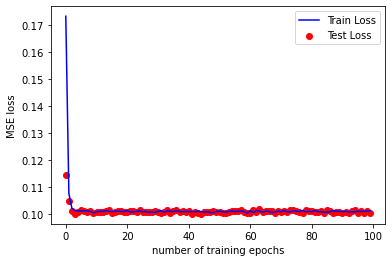

In [242]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_losses)), train_losses, color='blue')
plt.scatter(range(len(test_losses)), test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training epochs')
plt.ylabel('MSE loss')
plt.show()

In [271]:
#Testing Encoded sentence
#message = "It is time to test the model on real-world data"#. We must choose a sentence and an image. We choose the following sentence from Wikipedia: Anthony Edward \"Tony\" Stark is a character portrayed by Robert Downey Jr. in the MCU film franchise and for the image, we use the same Tony Stark’s image from the beginning of the article. The following code is used to embedding and extracting the message:"
message = "abcdefghijklmnopqrestuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"

In [272]:
def encrypt(message, model, secret_key, n = noise):
    message_index = [(ord(c)-32) for c in message]
    #print(message_index)
    #print(secret_key)
    #sk = secret_key.cpu()
    #print(sk.shape, sk.device)
    secret_message = secret_key[:, message_index]#.to(device)
    #print(secret_message[:,0])
    return model.f_encoder.apply_wnoise_realistic(secret_message, n)

In [283]:
encrypted_message = encrypt(message, model1, secret_key, n = 2)

tensor([[0., 0., 1.,  ..., 1., 1., 0.],
        [1., 1., 1.,  ..., 0., 1., 0.],
        [1., 1., 0.,  ..., 0., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]], device='cuda:0') torch.Size([1000, 53]) tensor(16., device='cuda:0')


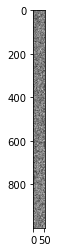

In [284]:
print(encrypted_message, encrypted_message.shape, torch.sum(encrypted_message[:,-1]-encrypted_message[:,-2]))
plt.imshow(encrypted_message.cpu().detach().numpy(),  cmap=plt.cm.gray)


In [285]:
def determine_letter(vec, secret_key):
    ind=torch.argmin(torch.norm(secret_key-vec,dim=0))
    #print(ind)
    return chr(ind+32)

def decrypt(encrypted_message, model, secret_key):
    m = ""
    raw_m = model.decrypt(encrypted_message)
    #print(raw_m[:,0], secret_key[:,41], torch.norm(raw_m[:,0]-secret_key[:,41]))
    for i in range(raw_m.shape[1]):
        m+=(determine_letter(raw_m[:,i].view(raw_m.shape[0],1),secret_key))
    return m

In [286]:
decrypted_m = decrypt(encrypted_message, model1, secret_key)
print(decrypted_m)
def decryption_accuracy(message, decrypted_message):
    count = 0
    for i in range(len(message)):
        if message[i] == decrypted_message[i]:
            count+=1
    return count/len(message) * 100
print("decryption accuracy is {}%".format(round(decryption_accuracy(message, decrypted_m), 2)))

abcdefghijklmnopqrestuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ
decryption accuracy is 100.0%


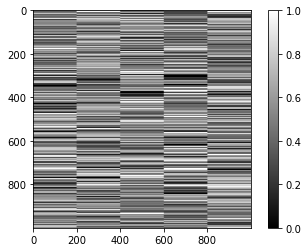

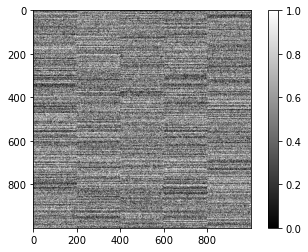

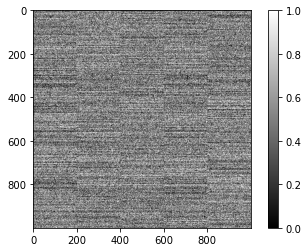

In [270]:
#Visualize variance caused by noise
def visualize(message, model, secret_key, n = noise):
    encrypted_message = encrypt(message, model, secret_key, n = n)
    #print(encrypted_message)
    #print(torch.sum(encrypted_message[:,1]-encrypted_message[:,0]))
    plt.imshow(encrypted_message.cpu().detach().numpy(),  cmap=plt.cm.gray)
    plt.colorbar()
    plt.show()

visualize("a"*200+"b"*200+"c"*200+"d"*200+"e"*200, model1, secret_key, n = 0)
visualize("a"*200+"b"*200+"c"*200+"d"*200+"e"*200, model1, secret_key, n = 2)
visualize("a"*200+"b"*200+"c"*200+"d"*200+"e"*200, model1, secret_key, n = 3)

In [202]:
#message_index = [(ord(c)-32) for c in message]
#print(message_index)
#secret_message = secret_key[:, message_index]#.to(device)
#output = model1(secret_message)
#print(output[:,0]-secret_message[:,0])

[41, 84, 0, 73, 83, 0, 84, 73, 77, 69, 0, 84, 79, 0, 84, 69, 83, 84, 0, 84, 72, 69, 0, 77, 79, 68, 69, 76, 0, 79, 78, 0, 82, 69, 65, 76, 13, 87, 79, 82, 76, 68, 0, 68, 65, 84, 65]
tensor([-5.3554e-01, -6.1449e-04,  1.4492e-01, -5.5073e-01,  1.0839e+00,
        -1.1452e+00,  2.3126e-01, -1.5485e-01, -1.0052e+00,  9.9301e-01],
       device='cuda:0', grad_fn=<SubBackward0>)
